In [49]:
source("../shared.R")

In [2]:
data("warpbreaks")

In [3]:
?warpbreaks

In [4]:
head(warpbreaks)

breaks,wool,tension
26,A,L
30,A,L
54,A,L
25,A,L
70,A,L
52,A,L


In [5]:
table(warpbreaks$wool, warpbreaks$tension)

   
    L M H
  A 9 9 9
  B 9 9 9

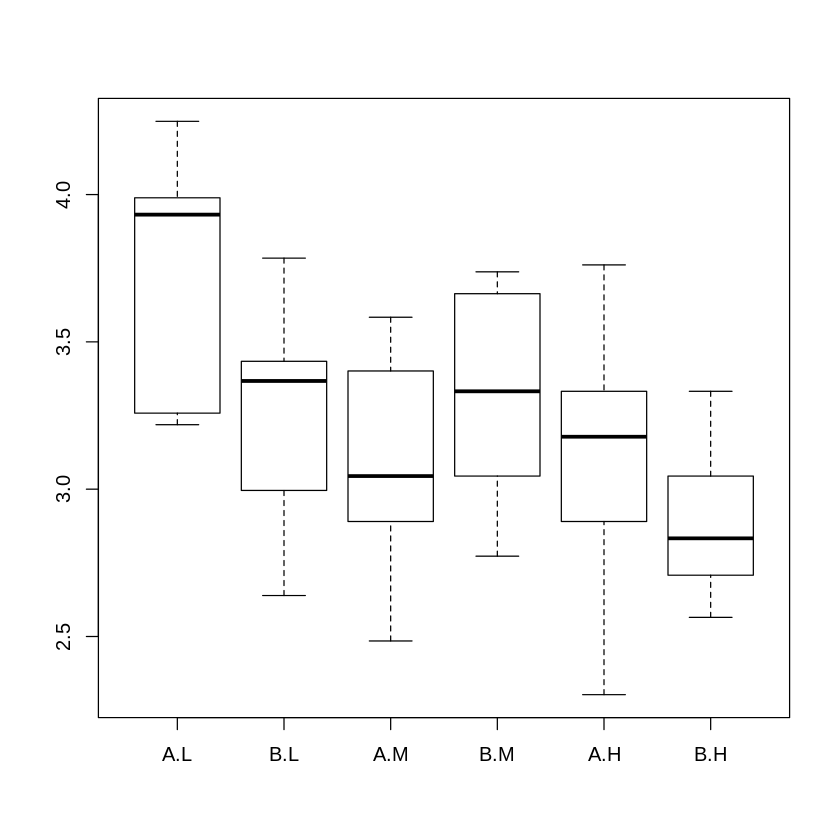

In [7]:
boxplot(log(breaks) ~ wool + tension, data = warpbreaks)

Different groups have mor similar simulation if we use $log(.)$ of the breaks. And we use it.

## One way model, where groups are split as tension

In [11]:
str(warpbreaks)

'data.frame':	54 obs. of  3 variables:
 $ breaks : num  26 30 54 25 70 52 51 26 67 18 ...
 $ wool   : Factor w/ 2 levels "A","B": 1 1 1 1 1 1 1 1 1 1 ...
 $ tension: Factor w/ 3 levels "L","M","H": 1 1 1 1 1 1 1 1 1 2 ...


In [10]:
smod = "model {
    for (i in 1: length(y)) {
        y[i] ~ dnorm(mu[tens_grp[i]], prec)
    }
    
    for (j in 1:3) {
        mu[j] ~ dnorm(0, 1./1e6) # low informative prior
    }
    
    prec ~ dgamma(5/2.0, 5*2/2.0) # 5 - sample size, 2 variation
    sig = sqrt(1./prec)  
}"

set.seed(83)

In [12]:
data =

In [18]:
data_ =  list(y = log(warpbreaks$breaks), tens_grp = as.numeric(warpbreaks$tension))
mod = jags_model_compile(str_model_ = smod, data_ = data_, n_chains_ = 3, burnout = 1e3)
mod_sim = jags_model_sample(mod, var_names_ = c("mu", "sig"), n_iter_ = 1e4)
mod_diag = jags_model_diag(mod_sim$samples)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 4
   Total graph size: 123

Initializing model



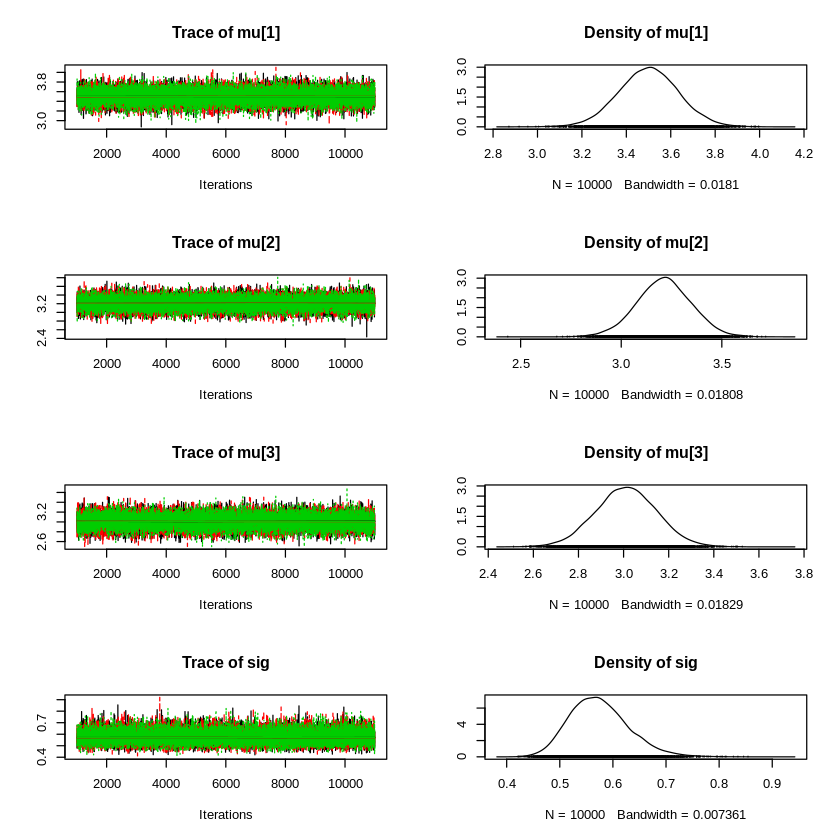

In [19]:
plot(mod_sim$samples)

In [25]:
dic1 = dic.samples(model = mod, n.iter = 1e4)

In [67]:
dic1

Mean deviance:  66.53 
penalty 4.052 
Penalized deviance: 70.58 

In [66]:
dic2

Mean deviance:  61.36 
penalty 5.145 
Penalized deviance: 66.51 

#### From the simulation we get the same results as we get them for just averaging them out

that is an expected behaviour

In [36]:
aggregate(log(warpbreaks$breaks), list(warpbreaks$tension), mean)

Group.1,x
L,3.500162
M,3.213038
H,3.010887


In [38]:
colMeans(mod_sim$samples_cmb)

mu[1]     mu[2]     mu[3]       sig 
3.5001958 3.2125871 3.0111630 0.5740963

In [24]:
summary(mod_sim$samples_cmb)


Iterations = 1:30000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
mu[1] 3.5002 0.13610 0.0007858      0.0007932
mu[2] 3.2126 0.13605 0.0007855      0.0007855
mu[3] 3.0112 0.13589 0.0007846      0.0008029
sig   0.5741 0.05547 0.0003203      0.0003372

2. Quantiles for each variable:

        2.5%   25%    50%    75%  97.5%
mu[1] 3.2326 3.410 3.5010 3.5900 3.7679
mu[2] 2.9408 3.123 3.2131 3.3023 3.4797
mu[3] 2.7443 2.921 3.0113 3.1026 3.2784
sig   0.4787 0.535 0.5699 0.6081 0.6952


### Two-way additive model (additive?)

In [39]:
X = model.matrix(~ wool + tension, data=warpbreaks)

In [43]:
smod = "model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = int + alpha*isWoolB[i] + beta[1]*isTeninsionM[i] + beta[2]*isTensionH[i]    
    }
    int ~ dnorm(0, 1.e-6)
    alpha ~ dnorm(0, 1.e-6)
    for (j in 1:2) {
        beta[j] ~ dnorm(0, 1.e-6)
    }
    prec ~ dgamma(3/2., 3.2)
    sig = sqrt(1/prec)
}"

In [45]:
dat = list(y=log(warpbreaks$breaks), isWoolB=X[,"woolB"], isTeninsionM=X[,"tensionM"], isTensionH=X[,"tensionH"]) 

In [60]:
jags_mod = jags_model_compile(smod, dat)
mod_sim = jags_model_sample(jags_mod, n_iter_ = 1e4, var_names_ = c("int", "alpha","beta", "sig"))
mod_diag = jags_model_diag(mod_sim$samples)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 5
   Total graph size: 242

Initializing model



In [63]:
summary(mod_sim$samples_cmb)


Iterations = 1:30000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD  Naive SE Time-series SE
alpha   -0.1507 0.14358 0.0008289       0.001441
beta[1] -0.2859 0.17458 0.0010080       0.002036
beta[2] -0.4896 0.17379 0.0010034       0.002059
int      3.5752 0.14299 0.0008256       0.002075
sig      0.5223 0.05177 0.0002989       0.000328

2. Quantiles for each variable:

           2.5%     25%     50%      75%    97.5%
alpha   -0.4332 -0.2456 -0.1508 -0.05543  0.13260
beta[1] -0.6269 -0.4036 -0.2856 -0.16728  0.05494
beta[2] -0.8353 -0.6034 -0.4884 -0.37396 -0.15134
int      3.2967  3.4789  3.5736  3.66964  3.86156
sig      0.4329  0.4857  0.5182  0.55402  0.63615


In [64]:
dic2 = dic.samples(jags_mod, n.iter = 1e4)

In [65]:
dic2

Mean deviance:  61.36 
penalty 5.145 
Penalized deviance: 66.51 

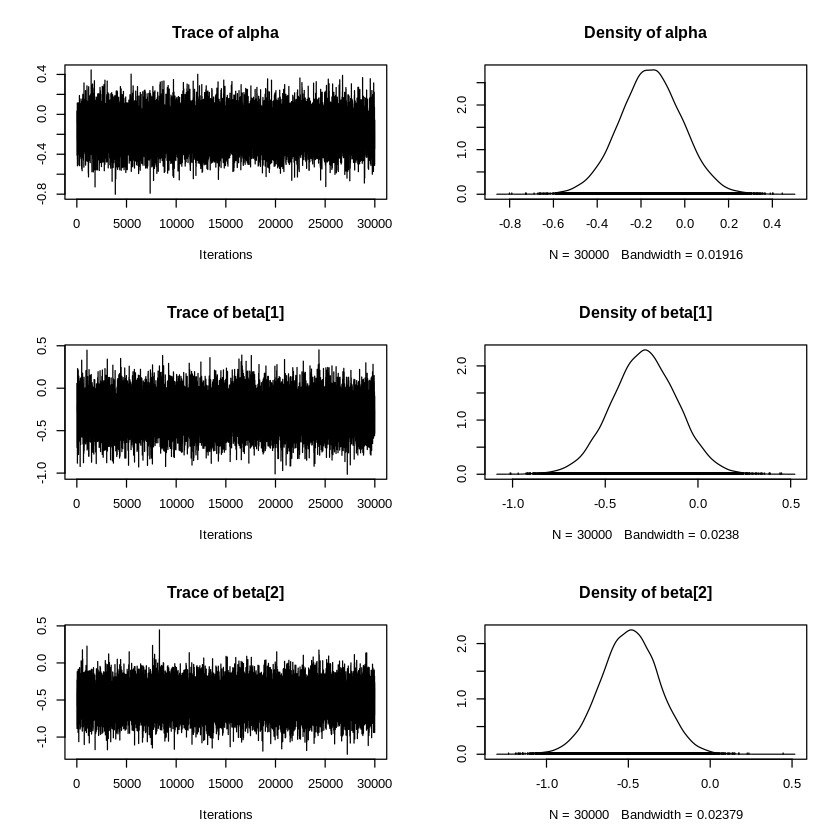

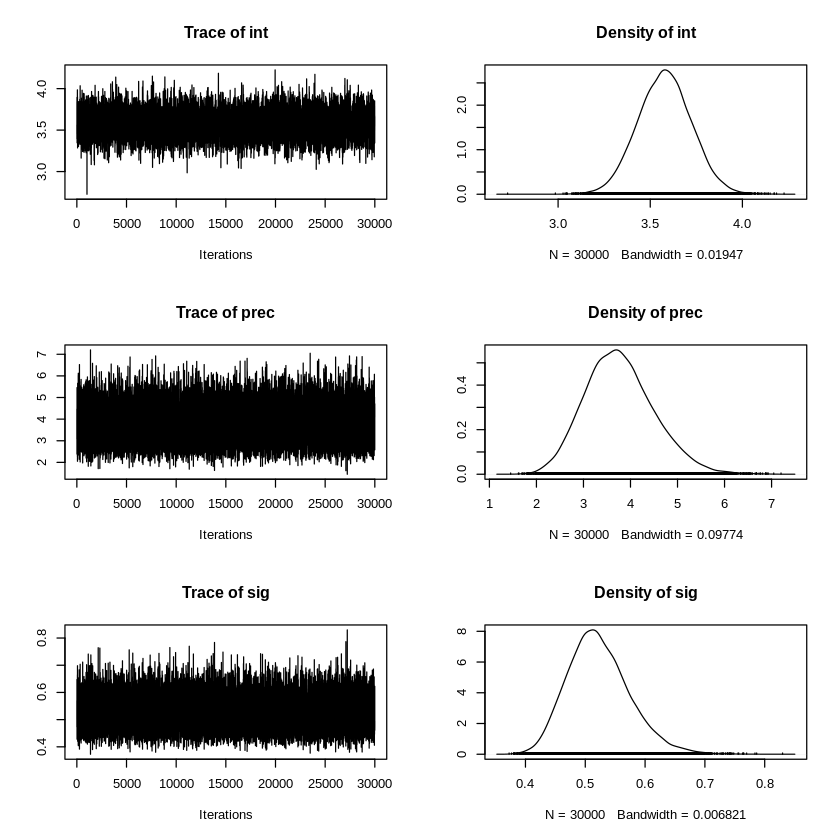

In [54]:
plot(mod_sim$samples_cmb)

In [79]:
smod = "model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[wool_group[i], tension_group[i]], prec[wool_group[i], tension_group[i]] )
    }
    # prec ~ dgamma(3/2.0, 3*1/2.9)
    # sig = sqrt(1/prec)
    for (j in 1:max(wool_group)) {
        for (k in 1:max(tension_group)) {
            mu[j,k] ~ dnorm(0, 1e-6)
            prec[j,k] ~ dgamma(1/2, 1/2)
            sig[j, k] = sqrt(1/prec[j,k])
        }
    }
}"
dat = list(y = log(warpbreaks$breaks), wool_group=as.numeric(warpbreaks$wool), tension_group=as.numeric(warpbreaks$tension) )
jags_mod = jags_model_compile(smod, dat)
mod_sim = jags_model_sample(jags_mod, var_names_ =c("mu", "sig"),n_iter_ = 1e4)
mod_diag = jags_model_diag(samples_ = mod_sim$samples)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 12
   Total graph size: 191

Initializing model



In [80]:
dic4 = dic.samples(jags_mod, n.iter = 1e4)

In [81]:
dic4

Mean deviance:  60.23 
penalty 14.49 
Penalized deviance: 74.72 

In [72]:
dic3 = dic.samples(jags_mod, n.iter = 1e4)

In [76]:
summary(mod_sim$samples_cmb)


Iterations = 1:30000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean      SD  Naive SE Time-series SE
mu[1,1] 3.7178 0.14118 0.0008151      0.0008151
mu[2,1] 3.2834 0.14050 0.0008112      0.0008112
mu[1,2] 3.1163 0.14087 0.0008133      0.0008133
mu[2,2] 3.3088 0.14129 0.0008158      0.0008050
mu[1,3] 3.1171 0.14120 0.0008152      0.0008152
mu[2,3] 2.9041 0.14079 0.0008129      0.0008234
sig     0.4208 0.04296 0.0002480      0.0002777

2. Quantiles for each variable:

          2.5%    25%    50%    75%  97.5%
mu[1,1] 3.4414 3.6251 3.7163 3.8114 3.9977
mu[2,1] 3.0066 3.1901 3.2839 3.3758 3.5590
mu[1,2] 2.8428 3.0229 3.1156 3.2093 3.3968
mu[2,2] 3.0298 3.2140 3.3090 3.4038 3.5852
mu[1,3] 2.8377 3.0242 3.1180 3.2100 3.3930
mu[2,3] 2.6274 2.8103 2.9043 2.9981 3.1785
sig     0.3472 0.3903 0.4174 0.4473 0.5143


In [74]:
dic1

Mean deviance:  66.53 
penalty 4.052 
Penalized deviance: 70.58 

In [73]:
dic2

Mean deviance:  61.36 
penalty 5.145 
Penalized deviance: 66.51 

In [75]:
dic3

Mean deviance:  50.28 
penalty 7.195 
Penalized deviance: 57.47 